In [1]:

# Default locations if parameter not passed
benchmark_data_path = "sim-compare.pkl"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'sim_device_number', 'sim_task_number', 'sim_rr',
       'sim_deviation', 'full_output', 'time'],
      dtype='object')

name  sim_device_number  sim_task_number  sim_rr  \
0  time-measure-task                100              100       2   
1  time-measure-task                100              100       2   
2  time-measure-task                100              100       2   
3  time-measure-task                100              100       2   
4  time-measure-task                100              100       2   

   sim_deviation                                        full_output      time  
0            NaN  Time Simulation (microseconds) : 1748 \nDistan...  0.151416  
1            NaN  Time Simulation (microseconds) : 1727 \nDistan...  0.186402  
2            NaN  Time Simulation (microseconds) : 1732 \nDistan...  0.173765  
3            NaN  Time Simulation (microseconds) : 1630 \nDistan...  0.178064  
4            NaN  Time Simulation (microseconds) : 1740 \nDistan...  0.188449

name  sim_device_number  sim_task_number  sim_rr  sim_deviation  \
1135  dist-measure                 20              500      16            5.0   
1136  dist-measure                 20              500      16            5.0   
1137  dist-measure                 20              500      16            5.0   
1138  dist-measure                 20              500      16            5.0   
1139  dist-measure                 20              500      16            5.0   

                                            full_output      time  
1135  Time Simulation (microseconds) : 1537 \nDistan...  0.199001  
1136  Time Simulation (microseconds) : 1543 \nDistan...  0.202257  
1137  Time Simulation (microseconds) : 1602 \nDistan...  0.201067  
1138  Time Simulation (microseconds) : 1536 \nDistan...  0.190556  
1139  Time Simulation (microseconds) : 1548 \nDistan...  0.197073

In [3]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [4]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [5]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()




Benchmark: time-measure-task - Runs: 10
--- Row 0 ---
name: time-measure-task
sim_device_number: 100
sim_task_number: 100
sim_rr: 2
sim_deviation: nan
full_output: Time Simulation (microseconds) : 1748 
Distance : 6.7393e-16


time: 0.15141612105071545

--- Row 1 ---
name: time-measure-task
sim_device_number: 100
sim_task_number: 100
sim_rr: 2
sim_deviation: nan
full_output: Time Simulation (microseconds) : 1727 
Distance : 6.92881e-16


time: 0.18640215997584164

--- Row 2 ---
name: time-measure-task
sim_device_number: 100
sim_task_number: 100
sim_rr: 2
sim_deviation: nan
full_output: Time Simulation (microseconds) : 1732 
Distance : 6.94304e-16


time: 0.17376493802294135

--- Row 3 ---
name: time-measure-task
sim_device_number: 100
sim_task_number: 100
sim_rr: 2
sim_deviation: nan
full_output: Time Simulation (microseconds) : 1630 
Distance : 6.93605e-16


time: 0.17806422989815474

--- Row 4 ---
name: time-measure-task
sim_device_number: 100
sim_task_number: 100
sim_rr: 2
sim_devia

# Experiment 1

time-measure-task

rr: fixed at 2
sim_device_number: fixed at 100
y: Execution time (last line) 
x: sim_task_number


In [6]:
import re
import numpy as np

def extract_sim_time(text):
    """
    From a blob like:
    
      "... Time Simulation (microseconds) : 874  \n Distance : 2.52673e-16 ..."
    
    extract 874, interpret it as microseconds, convert to seconds → 0.000874
    Returns np.nan if no match is found.
    """
    # look for "Time Simulation (microseconds) : <number>"
    matches = re.findall(
        r"Time Simulation\s*\(microseconds\)\s*:\s*([0-9]+(?:\.[0-9]*)?)",
        str(text),
    )
    if not matches:
        return np.nan
    # take the last one (in case there's more than one), convert to float, then to seconds
    micro = float(matches[-1])
    return micro * 1e-6
   

In [7]:
df_time_task = df[df["name"] == "time-measure-task"].copy()
df_time_task["sim_time"] = df_time_task["full_output"].apply(extract_sim_time)
df_time_task = df_time_task[["sim_task_number", "sim_time"]]

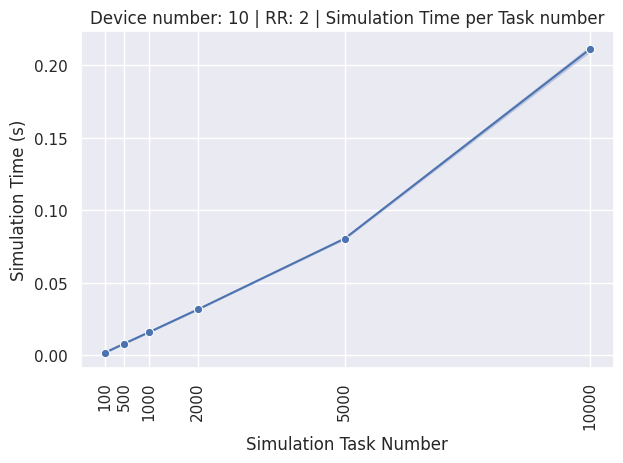

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_time_task and contains 'sim_task_number' and 'sim_time'
plt.figure()
sns.lineplot(
    data=df_time_task,
    x="sim_task_number",
    y="sim_time",
    marker="o",
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Simulation Task Number")
plt.ylabel("Simulation Time (s)")
plt.title("Device number: 10 | RR: 2 | Simulation Time per Task number")
plt.xticks(sorted(df_time_task["sim_task_number"].unique()))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 2: time-measure-device

sim_task_number: fixed at 1000
y_axis: Execution time
x_axis: sim_device_number

In [9]:
df_device_task = df[df["name"] == "time-measure-device"].copy()
df_device_task["sim_time"] = df_device_task["full_output"].apply(extract_sim_time)
df_device_task = df_device_task[["sim_device_number", "sim_time"]]

print(df_device_task.head())


    sim_device_number  sim_time
60                 10  0.000669
61                 10  0.000709
62                 10  0.000680
63                 10  0.000665
64                 10  0.000683


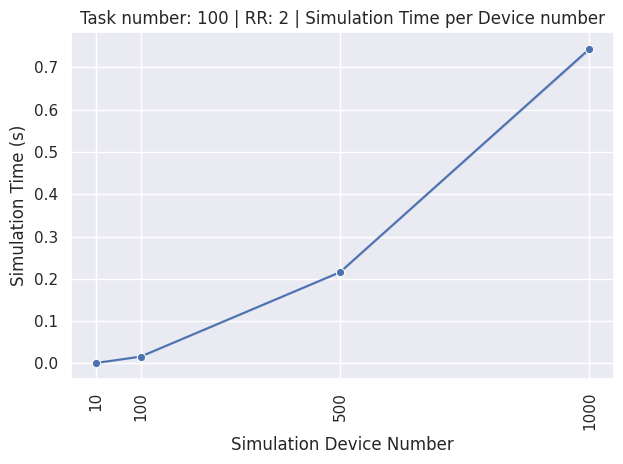

In [10]:
plt.figure()
sns.lineplot(
    data=df_device_task,
    x="sim_device_number",
    y="sim_time",
    marker="o",
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Simulation Device Number")
plt.ylabel("Simulation Time (s)")
plt.title("Task number: 100 | RR: 2 | Simulation Time per Device number")
plt.xticks(sorted(df_device_task["sim_device_number"].unique()))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 3

x-axsis: sim_devation
y-axis: distance (float)

one line per sim_rr

In [11]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Extraction
def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

# 2) Build df_dist
df_dist = df[df["name"] == "dist-measure"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["sim_deviation", "sim_rr", "distance"]]

print(df_dist.head())


     sim_deviation  sim_rr      distance
100            0.0       2  9.314420e-16
101            0.0       2  4.166880e-16
102            0.0       2  5.707050e-16
103            0.0       2  5.856790e-16
104            0.0       2  4.697840e-16


/tmp/ipykernel_3626796/1495727988.py:3: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(


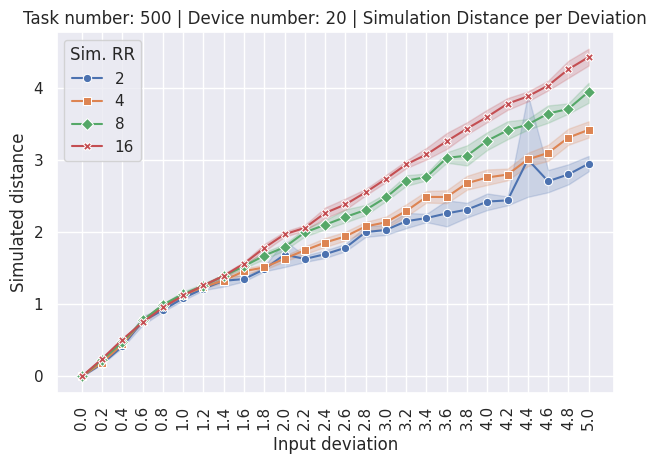

In [14]:
plt.figure()
markers = ["o", "s", "D", "X", "v", "^"]
sns.lineplot(
    data=df_dist,
    x="sim_deviation",
    y="distance",
    hue="sim_rr",
    style="sim_rr",
    markers=markers,
    dashes=False,
    palette="deep",
    errorbar="ci"
)
plt.xlabel("Input deviation")
plt.ylabel("Simulated distance")
plt.title("Task number: 500 | Device number: 20 | Simulation Distance per Deviation")
plt.legend(title="Sim. RR", loc="upper left")
plt.xticks(sorted(df_dist["sim_deviation"].unique()), rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()